In [2]:
%load_ext autoreload
%autoreload 2

from primitives.primitives import *
from primitives.tv_model import *
from primitives.spinful import *

from cirq import Circuit, LineQid, measure, sample, Simulator
import matplotlib.pyplot as plt
from numpy.linalg import eig
import re
from scipy.constants import hbar

simulator = Simulator()

In [21]:
def add_horizontal_hop_even(qudits, rows, cols, operator, circuit, spin):
    for row in range(rows):
        for col in range(cols):
            if col != cols - 1 and col%2==0:
                a = qudits[row][col][spin]
                b = qudits[row][col+1][spin]
                circuit.append(operator(a, b))
    return circuit
def add_horizontal_hop_odd(qudits, rows, cols, operator, circuit, spin):
    for row in range(rows):
        for col in range(cols):
            if col != cols - 1 and col%2!=0:
                a = qudits[row][col][spin]
                b = qudits[row][col+1][spin]
                circuit.append(operator(a, b))
    return circuit

def add_vertical_hop_even(qudits, rows, cols, operator, circuit, spin):
    for row in range(rows):
        for col in range(cols):
            if row != rows - 1 and row%2==0:
                a = qudits[row][col][spin]
                b = qudits[row+1][col][spin]
                circuit.append(operator(a, b))
    return circuit

def add_vertical_hop_odd(qudits, rows, cols, operator, circuit, spin):
    for row in range(rows):
        for col in range(cols):
            if row != rows - 1 and row%2!=0:
                a = qudits[row][col][spin]
                b = qudits[row+1][col][spin]
                circuit.append(operator(a, b))
    return circuit

def add_interaction(qudits, rows, cols, operator, circuit):
    for row in range(rows):
        for col in range(cols):
            circuit.append(operator(qudits[row][col][0], qudits[row][col][1]))
    return circuit

In [22]:
def evolve(qudits, temps, initial, J, U):

    if len(temps) > 1:
        ev_num = evolve_gate(SpinfulNumberGate)(C=U, t = (temps[1]-temps[0])/2)
        ev_xhop = evolve_gate(HopXGate)(C=J, t = (temps[1]-temps[0])/2)
        ev_yhop = evolve_gate(HopYGate)(C=J, t = (temps[1]-temps[0])/2)

    rows, cols, _ = qudits.shape
    results = []
    evolution_circuit = []
    for idx, t in enumerate(temps):
        print(f"Temp {t}")
        if t != 0:
            evolution_circuit = add_horizontal_hop_even(qudits, rows, cols, ev_xhop, evolution_circuit, 0)
            evolution_circuit = add_horizontal_hop_even(qudits, rows, cols, ev_xhop, evolution_circuit, 1)
            evolution_circuit = add_horizontal_hop_odd(qudits, rows, cols, ev_xhop, evolution_circuit, 0)
            evolution_circuit = add_horizontal_hop_odd(qudits, rows, cols, ev_xhop, evolution_circuit, 1)
            evolution_circuit = add_vertical_hop_even(qudits, rows, cols, ev_yhop, evolution_circuit, 0)
            evolution_circuit = add_vertical_hop_even(qudits, rows, cols, ev_yhop, evolution_circuit, 1)
            evolution_circuit = add_vertical_hop_odd(qudits, rows, cols, ev_yhop, evolution_circuit, 0)
            evolution_circuit = add_vertical_hop_odd(qudits, rows, cols, ev_yhop, evolution_circuit, 1)
            
            evolution_circuit = add_interaction(qudits, rows, cols, ev_num, evolution_circuit)
            
            evolution_circuit = add_interaction(qudits, rows, cols, ev_num, evolution_circuit)
            
            evolution_circuit = add_vertical_hop_odd(qudits, rows, cols, ev_yhop, evolution_circuit, 0)
            evolution_circuit = add_vertical_hop_odd(qudits, rows, cols, ev_yhop, evolution_circuit, 1)
            evolution_circuit = add_vertical_hop_even(qudits, rows, cols, ev_yhop, evolution_circuit, 0)
            evolution_circuit = add_vertical_hop_even(qudits, rows, cols, ev_yhop, evolution_circuit, 1)
            evolution_circuit = add_horizontal_hop_odd(qudits, rows, cols, ev_xhop, evolution_circuit, 0)
            evolution_circuit = add_horizontal_hop_odd(qudits, rows, cols, ev_xhop, evolution_circuit, 1)
            evolution_circuit = add_horizontal_hop_even(qudits, rows, cols, ev_xhop, evolution_circuit, 0)
            evolution_circuit = add_horizontal_hop_even(qudits, rows, cols, ev_xhop, evolution_circuit, 1)

        circuit = Circuit([*initial, *evolution_circuit])
        results.append((circuit, simulator.simulate(circuit)))
            
    return results

### Evolve a lattice

In [23]:
def get_spin_plaquettes(qudits):
    rows, cols, _ = qudits.shape
    plaquettes = []
    for row in range(rows):
        for col in range(cols):
            if col != cols - 1 and row != rows - 1:
                pl = [
                    qudits[row][col][0],
                    qudits[row][col + 1][0],
                    qudits[row + 1][col + 1][0],
                    qudits[row + 1][col][0],
                ]
                plaquettes.append(pl)
                pl = [
                    qudits[row][col][1],
                    qudits[row][col + 1][1],
                    qudits[row + 1][col + 1][1],
                    qudits[row + 1][col][1],
                ]    
                plaquettes.append(pl)
    return plaquettes

In [24]:
J = -1
U = 0.5

rows = 2
columns = 3
qudits = np.array(LineQid.range(rows * columns * 2, dimension=4)).reshape(rows, columns, 2)

In [25]:
final_T = 1.5
num_steps = 30
dt = final_T / num_steps

temps = np.arange(0, final_T+dt/2, dt)
print(temps)

plaquettes = get_spin_plaquettes(qudits)
projected_subspace = [Project_Constraint()(*pl) for pl in plaquettes]


coeffs = [1, 1] #+4j, 1+2j]

initial_state = [
    AddDiagTriple(*coeffs)(qudits[0][0][0], qudits[0][1][0], qudits[1][1][0]),
    AddHorizontalPair()(qudits[0][0][1], qudits[0][1][1]),
]

initial_circuit = [*projected_subspace, *initial_state]

# results is a list of tuples, every tuple contains the circuit and the result shots
results = evolve(qudits, temps, initial_circuit, J, U)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5 ]
Temp 0.0
Temp 0.05
Temp 0.1
Temp 0.15000000000000002
Temp 0.2
Temp 0.25
Temp 0.30000000000000004
Temp 0.35000000000000003
Temp 0.4
Temp 0.45
Temp 0.5
Temp 0.55
Temp 0.6000000000000001
Temp 0.65
Temp 0.7000000000000001
Temp 0.75
Temp 0.8
Temp 0.8500000000000001
Temp 0.9
Temp 0.9500000000000001
Temp 1.0
Temp 1.05
Temp 1.1
Temp 1.1500000000000001
Temp 1.2000000000000002
Temp 1.25
Temp 1.3
Temp 1.35
Temp 1.4000000000000001
Temp 1.4500000000000002
Temp 1.5


In [26]:
results[0][0]

┌────┐   ┌────┐   ┌─────────┐
0 (d=4): ─────P+────────────────f+(A+B)──────
              │                 │
1 (d=4): ─────┼─P+──────────────┼──────f+────
              │ │               │      │
2 (d=4): ─────P+┼──────P+───────f+(A)──┼─────
              │ │      │        │      │
3 (d=4): ─────┼─P+─────┼─P+─────┼──────f+────
              │ │      │ │      │
4 (d=4): ─────┼─┼──────P+┼──────┼────────────
              │ │      │ │      │
5 (d=4): ─────┼─┼──────┼─P+─────┼────────────
              │ │      │ │      │
6 (d=4): ─────P+┼──────┼─┼──────┼────────────
              │ │      │ │      │
7 (d=4): ─────┼─P+─────┼─┼──────┼────────────
              │ │      │ │      │
8 (d=4): ─────P+┼──────P+┼──────f+(B)────────
                │      │ │
9 (d=4): ───────P+─────┼─P+──────────────────
                       │ │
10 (d=4): ─────────────P+┼───────────────────
                         │
11 (d=4): ───────────────P+──────────────────
             └────┘   └────┘   └─────────┘

In [27]:
v = results[0][1].state_vector()
(np.zeros(v.shape) == v).all()

False

### Operators

In [28]:
line_styles = ['-.', '--', '-.', ':']*3
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p']*2

0
1
2
3


(-1.1, 1.1)

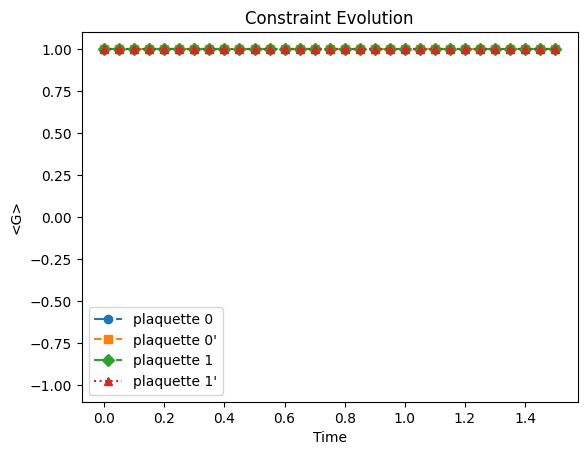

In [29]:
evol_res = {str(idx): [] for idx in range(len(plaquettes))}

for idx, plaquette in enumerate(plaquettes):
    print(idx)
    for state in results:
        operator = G
        val = expectation_value(state[1], plaquette, operator)
        evol_res[str(idx)].append(np.abs(val))

for idx, i in enumerate(evol_res):
    name = idx // 2
    if idx % 2 == 1:
        name = str(name)+"'"
    plt.plot(temps, evol_res[i], label=f"plaquette {name}", linestyle=line_styles[idx], marker=markers[idx])
    
plt.title("Constraint Evolution")
plt.xlabel("Time")
plt.ylabel("<G>")
plt.legend()
plt.ylim(-1.1, 1.1)

### Numbers

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


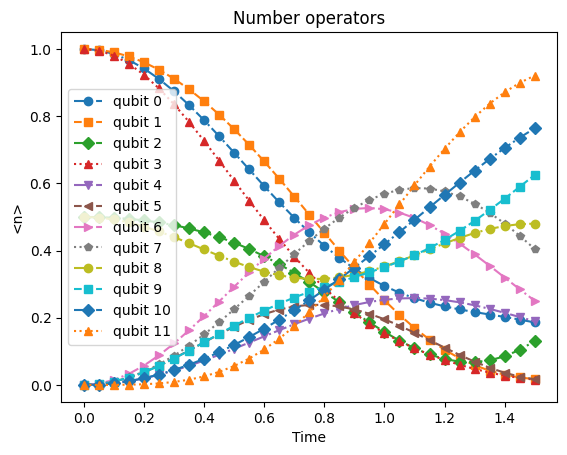

In [34]:
num_evol_res = []

for idx, state in enumerate(results):
    nums = compute_state_exp_numbers(qudits, state)
    num_evol_res.append(nums)
    
num_evol_res = np.array(num_evol_res)

for i in range(len(qudits.flatten())):
    plt.plot(temps, num_evol_res[:,i], label=f"qubit {i}", linestyle=line_styles[i], marker=markers[i])
    
plt.title("Number operators")
plt.xlabel("Time")
plt.ylabel("<n>")
plt.legend()

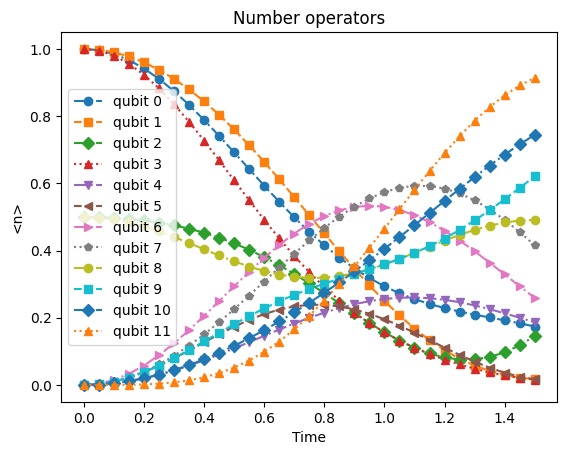

In [30]:
num_evol_res = []

for idx, state in enumerate(results):
    nums = compute_state_exp_numbers(qudits, state)
    num_evol_res.append(nums)
    
num_evol_res = np.array(num_evol_res)

for i in range(len(qudits.flatten())):
    plt.plot(temps, num_evol_res[:,i], label=f"qubit {i}", linestyle=line_styles[i], marker=markers[i])
    
plt.title("Number operators")
plt.xlabel("Time")
plt.ylabel("<n>")
plt.legend()

In [36]:
np.sum(num_evol_res, axis=1)

array([4.        , 4.00000048, 4.0000004 , 4.00000036, 4.00000051,
       4.0000003 , 4.00000061, 3.99999913, 4.00000036, 3.99999938,
       3.99999963, 4.00000004, 3.99999974, 3.99999992, 4.00000054,
       3.9999995 , 3.99999929, 4.00000039, 3.9999998 , 3.99999956,
       4.00000088, 4.00000113, 4.00000068, 4.00000008, 4.00000091,
       4.00000023, 4.00000095, 4.00000024, 4.00000052, 4.00000105,
       4.00000048])

### Hamiltonian

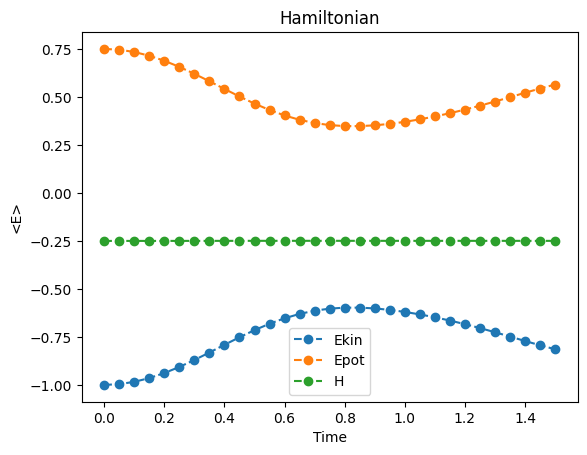

In [31]:
ekin = []
epot = []

for state in results:
    ham_k, ham_p = compute_state_exp_hamiltonian_fh(qudits, state, J, U)
    ekin.append(ham_k)
    epot.append(ham_p)

ekin = np.array(ekin)
epot = np.array(epot)

plt.plot(temps, ekin, "o--", label="Ekin")
plt.plot(temps, epot, "o--", label="Epot")
plt.plot(temps, ekin+epot, "o--", label="H")
    
plt.title("Hamiltonian")
plt.xlabel("Time")
plt.ylabel("<E>")
plt.legend()

In [32]:
ekin, epot

(array([-1.        , -0.99594409, -0.98392967, -0.96442793, -0.93820851,
        -0.90633917, -0.87015489, -0.83120602, -0.79117749, -0.7517959 ,
        -0.71471164, -0.68137548, -0.65293815, -0.6301707 , -0.61343547,
        -0.60269112, -0.59756194, -0.59743349, -0.60156933, -0.60923482,
        -0.61978694, -0.63274153, -0.64778185, -0.66472688, -0.68346031,
        -0.70383522, -0.72558938, -0.74826603, -0.77119077, -0.79348645,
        -0.81412817]),
 array([0.75      , 0.74595   , 0.73395562, 0.71448337, 0.68830628,
        0.65649133, 0.62037042, 0.58148917, 0.54153117, 0.50221766,
        0.46519209, 0.43190276, 0.40349679, 0.38074514, 0.36400807,
        0.35324928, 0.34809676, 0.34794059, 0.35205048, 0.35969394,
        0.37023225, 0.38318078, 0.39822177, 0.41517092, 0.43390662,
        0.45427944, 0.47602121, 0.49867612, 0.52156968, 0.54382439,
        0.56442304]))

In [34]:
import json
RESULTS = {
    "ham": (ekin+epot).tolist(),
    "ekin": ekin.tolist(),
    "epot": epot.tolist(),
    "nums": num_evol_res.tolist(),
    "temps": temps.tolist(),
}
with open("spinful_data_sim.json", "w") as file:
    json.dump(RESULTS, file)

## Check Trotter

In [ ]:
final_T = 0.6

nums_steps = [1, 2, 4, 8]


final_results_k = []
final_results_p = []
final_results_h = []
final_results_nums = []

for num_steps in nums_steps:
    print(f"Doing {num_steps} steps")
    
    dt = final_T / num_steps
    temps = np.arange(0, final_T+dt/2, dt)
    # results is a list of tuples, every tuple contains the circuit and the result shots
    results = evolve(qudits, temps, initial_circuit, J=J, U=U)

    ham_k, ham_p = compute_state_exp_hamiltonian_fh(qudits, results[-1], J, U)
    final_results_k.append(ham_k)
    final_results_p.append(ham_p)
    final_results_h.append(ham_k+ham_p)

    nums = compute_state_exp_numbers(qudits, results[-1])
    final_results_nums.append(nums)

In [ ]:
# Tmax = 0.6


nk_val_k = -0.6535
nk_val_p = 0.4035
nk_val_h = nk_val_k+nk_val_p

nk_numbers = np.array([0.593, 0.6637, 0.3805, 0.4916, 0.1461, 0.2107,
                       0.3784, 0.3077, 0.3389, 0.2278, 0.1631, 0.0984])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

final_results_k = np.array(final_results_k)
final_results_p = np.array(final_results_p)

ax1.plot(nums_steps, final_results_k, "-o", label="Ekin")
ax1.axhline(nk_val_k, linestyle="--", label="NK kin")
ax1.set_xlabel("Number of steps")
ax1.set_title("Ekin")

ax2.plot(nums_steps, final_results_p, "-o", label="Epot")
ax2.axhline(nk_val_p, linestyle="--", label="NK pot")
ax2.set_xlabel("Number of steps")
ax2.set_title("Epot")

ax3.plot(nums_steps, final_results_h, "-o", label="Etot")
ax3.axhline(nk_val_h, linestyle="--", label="NK tot")
ax3.set_xlabel("Number of steps")
ax3.set_title("Etot")

num_error = [np.sum(np.abs(nk_numbers - i)) for i in final_results_nums]
ax4.plot(nums_steps, num_error, "-o", label="Etot")
ax4.axhline(0, linestyle="--", label="NK tot")
ax4.set_xlabel("Number of steps")
ax4.set_title("Tot error on nums")